In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import numpy as np
from tensorflow.python.keras import models
from scipy.optimize import fmin_l_bfgs_b

from IPython import display
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout,Add

## Reshape Image

In [0]:
!unzip 'train2014.zip'

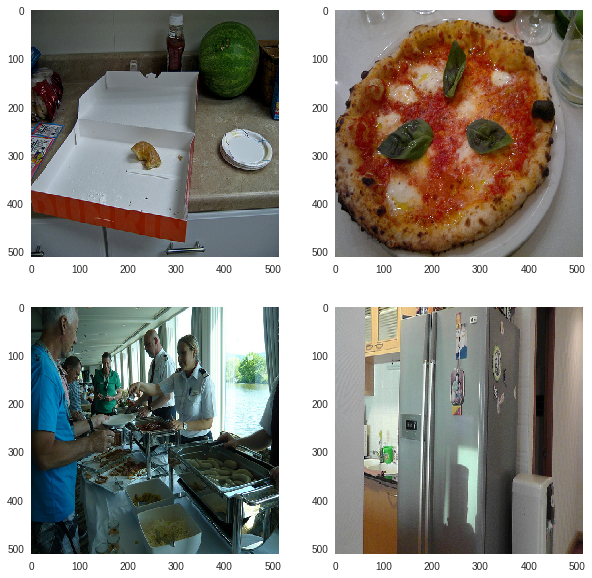

In [2]:
height = 512
width  = 512

from os import listdir

def loadImages(path):
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
      if image[::-1][:4] == '.jpg'[::-1]:
        img = Image.open(path + image)
        img = img.resize((width, height))
        loadedImages.append(img)
    return loadedImages
  
path = "./train2014/"
content_images = loadImages(path)
n=len(content_images)
plt.figure(figsize=(10,10))
for j,i in enumerate(np.random.choice(n,4)):
    plt.subplot(2,2,j+1)
    plt.imshow(content_images[i])
    plt.grid(False)

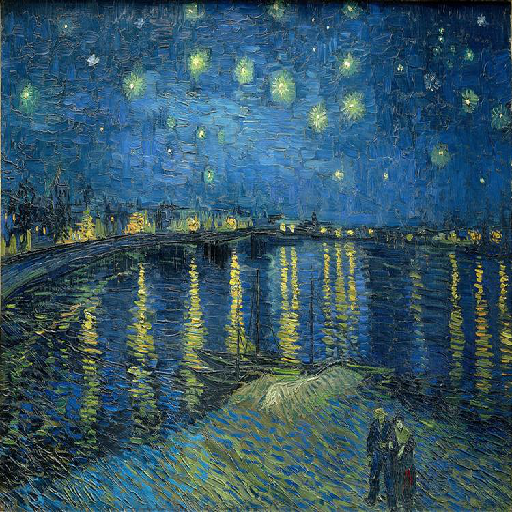

In [3]:
style_image_path = 'starry_night.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

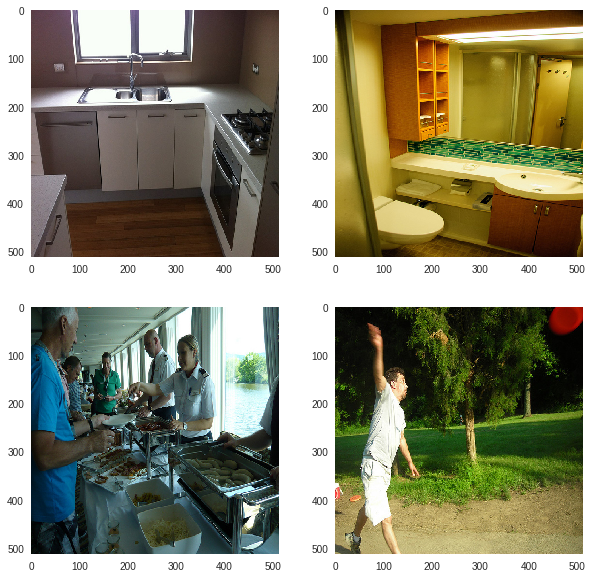

In [4]:
#small test data
plt.figure(figsize=(10,10))
for j,i in enumerate(content_images[:4]):
    plt.subplot(2,2,j+1)
    plt.imshow(i)
    plt.grid(False)

In [5]:
content_array = np.zeros(shape=(n, width, height, 3), dtype='float32')
for i in range(n):
  content_array[i,:,:,:] = np.asarray(content_images[i], dtype='float32')
  
style_array   = np.asarray(style_image, dtype='float32')
print(content_array.shape)
print(style_array.shape)

(104, 512, 512, 3)
(512, 512, 3)


In [6]:
# content_array = np.expand_dims(content_array, axis=0)
style_array = np.expand_dims(style_array, axis=0)
print(content_array.shape)
print(style_array.shape)

(104, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
content_array=content_array[:4,:,:,:]

In [0]:
content_array=tf.keras.applications.vgg16.preprocess_input(content_array)

In [0]:
style_array=tf.keras.applications.vgg16.preprocess_input(style_array)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(content_array).shuffle(n).batch(4).prefetch(1)

## Model 1: Transform Net

In [0]:
class TransformNet(tf.keras.Model):
  def __init__(self):
    super(TransformNet, self).__init__()
    # encode block
    self.block1_conv1 = Conv2D(filters=32, kernel_size=(9,9), strides=1, padding="same")
    self.block1_batchnorm1 = BatchNormalization(axis=3)
    self.block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same")
    self.block1_batchnorm2 = BatchNormalization(axis=3)
    self.block1_conv3 = Conv2D(filters=128, kernel_size=(3,3), strides=2, padding="same")
    self.block1_batchnorm3 = BatchNormalization(axis=3)
    # residual net block
    self.block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm1 = BatchNormalization(axis=3)
    self.block2_add1 = Add()
    self.block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm2 = BatchNormalization(axis=3)
    self.block2_add2 = Add()
    self.block2_conv3 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm3 = BatchNormalization(axis=3)
    self.block2_add3 = Add()
    self.block2_conv4 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm4 = BatchNormalization(axis=3)
    self.block2_add4 = Add()
    self.block2_conv5 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm5 = BatchNormalization(axis=3)
    self.block2_add5 = Add()
    # decode block
    self.block3_conv1transpose = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding="same")
    self.block3_batchnorm1 = BatchNormalization(axis=3)
    self.block3_conv2transpose = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding="same")
    self.block3_batchnorm2 = BatchNormalization(axis=3)
    self.block3_conv3transpose = Conv2D(filters=3, kernel_size=(9,9), strides=1, padding="same")
    self.block3_batchnorm3 = BatchNormalization(axis=3)
    
  def call(self, x, training=True):
    # encode block
    #x = tf.reshape(x,(-1,512,512,3))
    #x /= 255
    #x = x[0,:,:,:]
    #x -=[0.485, 0.456, 0.406]
    #x /=[0.229, 0.224, 0.225]
    #x = tf.keras.applications.vgg16.preprocess_input(x)
    x = tf.reshape(x,(-1,512,512,3))
    x = self.block1_conv1(x)
    x = self.block1_batchnorm1(x, training=training)
    x = tf.nn.relu(x)
    x = self.block1_conv2(x)
    x = self.block1_batchnorm2(x, training=training)
    x = tf.nn.relu(x)
    x = self.block1_conv3(x)
    x = self.block1_batchnorm3(x, training=training)
    x = tf.nn.relu(x)
    # residual block
    x1 = x
    x = self.block2_conv1(x)
    x = self.block2_batchnorm1(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add1([x, x1])
    x1 = x
    x = self.block2_conv2(x)
    x = self.block2_batchnorm2(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add2([x, x1])
    x1 = x
    x = self.block2_conv3(x)
    x = self.block2_batchnorm3(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add3([x, x1])
    x1 = x
    x = self.block2_conv4(x)
    x = self.block2_batchnorm4(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add4([x, x1])
    x1 = x
    x = self.block2_conv5(x)
    x = self.block2_batchnorm5(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_add5([x, x1])
    
    # decode block
    x = self.block3_conv1transpose(x)
    x = self.block3_batchnorm1(x,training=training)
    x = tf.nn.relu(x)
    x = self.block3_conv2transpose(x)
    x = self.block3_batchnorm2(x,training=training)
    x = tf.nn.relu(x)
    x = self.block3_conv3transpose(x)
    x = self.block3_batchnorm3(x,training=training)
    x = tf.nn.relu(x)
    #x = x[0,:,:,:]
    #x *= [0.229, 0.224, 0.225]
    #x += [0.485, 0.456, 0.406]
    #x *= 255
    #x = tf.clip_by_value(x,0,255)
    #x = tf.reshape(x,(-1,512,512,3))
    return x

## Model 2: VGG16

In [0]:
class VGG16_Model(tf.keras.Model):
  def __init__(self):
    super(VGG16_Model, self).__init__()
    self.vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=(512, 512, 3), include_top=False)
  
  def call(self, x, training=True):
    self.vgg16.trainable=False
    content_outputs = [self.vgg16.get_layer(l).output for l in layers_content]  # 0 content features
    style_outputs   = [self.vgg16.get_layer(l).output for l in layers_style]    # 1: style features
    outputs = content_outputs + style_outputs
    model=models.Model(self.vgg16.input,outputs)
    x = model(x)
    return x

In [0]:
transform_net= TransformNet()
vgg16 = VGG16_Model()

## Compute Loss

In [0]:
def content_loss(y_hat_features,content_features):
  _,h,w,N = content_features.shape
  #norm=tf.divide(1,tf.multiply(tf.multiply(w,h),N))
  M=tf.cast(tf.multiply(h,w),tf.float32)
  N=tf.cast(N,tf.float32)
  norm=tf.divide(1,tf.multiply(M,N))
  content_l = tf.reduce_sum(tf.square(y_hat_features-content_features))
  return tf.multiply(norm, content_l)

In [0]:
def gram_matrix(feature_tensor):
  channel = int(feature_tensor.shape[-1])
  feature_2d=feature_tensor[0,:,:,:]
  feature_2d=tf.reshape(feature_tensor, [-1, channel])
  feature_2d=tf.matmul(feature_2d, feature_2d, transpose_a=True)
  return feature_2d

In [0]:
def style_loss_per_layer(y_hat_features,style_features):
  y_hat_gram=gram_matrix(y_hat_features)
  style_gram=gram_matrix(style_features)
  _,h,w,N,=style_features.shape
  M=tf.cast(tf.multiply(h,w),tf.float32)
  N=tf.cast(N,tf.float32)
  norm=tf.divide(1.0,tf.multiply(M,N))
  norm=tf.pow(norm,2)
  style_l=tf.reduce_sum(tf.square(style_gram-y_hat_gram))
  return tf.multiply(norm,style_l)

In [0]:
def style_loss(y_hat_features_lst, style_features_lst):
  style_score=0
  style_weight_per_layer=1.0/float(len(style_features_lst))  #uniformly
  for i in range(len(style_features_lst)):
    style_loss_single=style_loss_per_layer(y_hat_features_lst[i],style_features_lst[i])
    style_score += style_weight_per_layer * style_loss_single
  return style_score

In [0]:
def variation_loss(y_hat,height,width,beta):
  a = tf.square(y_hat[:, :height-1, :width-1, :] - y_hat[:, 1:, :width-1, :])   
  b = tf.square(y_hat[:, :height-1, :width-1, :] - y_hat[:, :height-1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, beta/2))

In [0]:
def compute_loss(model,y_hat,content_image,style_image,
                 content_weight,style_weight,variation_weight,beta):
  
  content_features=model(content_image) 
  style_features_lst=model(style_image)
  y_hat_features=model(y_hat)                
  
  loss_c = content_loss(y_hat_features[0], content_features[0])
  loss_s = style_loss(y_hat_features[1:], style_features_lst[1:])
  loss_var = variation_loss(y_hat, height, width, beta)
  l = content_weight * loss_c + style_weight * loss_s + variation_weight * loss_var
  #l = content_weight * loss_c
  return l, loss_c, loss_s, loss_var

In [0]:
opt = tf.train.AdamOptimizer(learning_rate=1e-1)

In [0]:
epochs = 100

In [0]:
content_weight=1.
style_weight=5.
variation_weight=1e-6
beta=2.5

layers_content = ['block2_conv2']
layers_style = ['block1_conv2', 'block2_conv2','block3_conv2', 'block4_conv2','block5_conv2']

In [0]:
def train_step(model,content_image,style_image):
  
  with tf.GradientTape() as tape:
    
    y_hat = transform_net(content_image, training=True)
    total_loss, loss_c, loss_s, loss_var =compute_loss(model,y_hat,content_image,style_image,
                                                       content_weight,style_weight,variation_weight,beta)

  grads = tape.gradient(total_loss, transform_net.variables)
  opt.apply_gradients(zip(grads, transform_net.variables))
  return total_loss, loss_c, loss_s, loss_var

In [0]:
# Compile the training step with defun for increased performance.
# Comment out this line for easier debugging.
train_step = tf.contrib.eager.defun(train_step)

In [0]:
tfe = tf.contrib.eager

In [0]:
means=[103.939, 116.779,123.68]

In [0]:
def generate_and_display():
  display.clear_output(wait=True)
  y_hats = transform_net(content_array,training=False)
  
  imgs=[]
  for i in range(y_hats.shape[0]):
    y_hat=y_hats[i,:,:,:]+means
    y_hat = y_hat[:, :,::-1]
    y_hat = np.clip(y_hat,0,255).astype('uint8')
    imgs.append(y_hat)
  
  fig = plt.figure(figsize=(10,10))
  for i in range(len(imgs)):  
    plt.subplot(4,4, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
  plt.show()  

In [0]:
for epoch in range(epochs):
  start = time.time()
  l_t, loss_c, loss_s, loss_var=train_step(vgg16,content_array[0],style_array)
  end = time.time()
  generate_and_display()
  print ('Epoch {}. Seconds {}'.format(epoch, end - start))
  print ('Epoch {}. Total Loss {}'.format(epoch,l_t))
  print ('Epoch {}. Content Loss {}'.format(epoch,loss_c))
  print ('Epoch {}. Style Loss {}'.format(epoch,loss_s))
  print ('Epoch {}. Variation Loss {}'.format(epoch,loss_var))
  print ('Epoch {}. Grads {}'.format(epoch,grads))

In [0]:
train_step(vgg16,content_array,style_array)

In [0]:
result_img=transform_net(content_array,training=False)
result_img=result_img.numpy()[3,:,:,:]+means
result_img=result_img[:,:,::-1]
plt.figure(figsize=(10,10))
plt.imshow(np.clip(result_img,0,255).astype('uint8'))
plt.grid(False)
plt.axis('off')
plt.savefig("content_beta.png",bbox_inches='tight')

In [0]:
transform_net(content_array, training=False)